In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Experiment

We asume the triangle DAG with edges
1. X1 -> X2
2. X2 -> X3
3. X1 -> X3

which we know up to its Markov equivalence class but obtain natural interventions on variables with some degree of sparsity.

We begin with a domain of the original graph, then sample additional domans with some number of interventions. We either then pool all together, or consider pairwise pooling taking the union across pools.

In [2]:
# Meeks rules giving the oritentations are commented above
intervention_dict = {
    # 2 v-structures
    (1,): [1, 3],
    # 2 v-structure, acyclic
    (2,): [1, 2, 3],
    # 2 v-structures
    (3,): [2, 3],
    # 2 v-structures
    (1, 2): [2, 3],
    # 2 v-structures
    (2, 3): [1, 3],
    # 2 v-structures, acyclic
    (1, 3): [1, 2, 3],
    # Nothing
    (1, 2, 3): [],
}

In [3]:
class FullPC:
    def __init__(self):
        self.domains_ = []
        self.interv_edges_ = set()
        
    def add_domain(self, interventions):
        self.interv_edges_.update(interventions)
        self.domains_.append(interventions)
        
    def get_learned_edges(self):
        if len(self.domains_) == 1:
            return []
        else:
            return intervention_dict[tuple(sorted(self.interv_edges_))]
    
class PairwisePC:
    def __init__(self):
        self.domains_ = []
        self.learned_edges_ = []

    def add_domain(self, interventions):        
        for prior_domain in self.domains_:
            self.learned_edges_.append(intervention_dict[tuple(
                sorted(np.unique(np.hstack((prior_domain, interventions))))
            )])
        
        self.domains_.append(interventions)
        
    def get_learned_edges(self):
        if len(self.domains_) == 1:
            return []
        else:
            return np.unique(np.hstack(self.learned_edges_)).astype(int)

In [4]:
print('Pairwise')
fpc = PairwisePC()
fpc.add_domain([2])
print(fpc.get_learned_edges())
fpc.add_domain([3])
print(fpc.get_learned_edges())

print('Full')
fpc = FullPC()
fpc.add_domain([2])
print(fpc.get_learned_edges())
fpc.add_domain([3])
print(fpc.get_learned_edges())

Pairwise
[]
[1 3]
Full
[]
[1, 3]


## Experiments

In [5]:
results_mat = []
n_environments = 15
n_reps = 200

for rep in range(n_reps):
    for sparsity in [1, 2, 3]:
        fpc = FullPC()    
        ppc = PairwisePC()
        for n_env in range(1, n_environments+1):
            interventions = tuple(np.random.choice([1, 2, 3], sparsity, replace=False))
            fpc.add_domain(interventions)
            ppc.add_domain(interventions)
            results_mat.append([
                rep, 'Full PC', sparsity, n_env, len(fpc.get_learned_edges())
            ])
            results_mat.append([
                rep, 'Pairwise PC', sparsity, n_env, len(ppc.get_learned_edges())
            ])

In [6]:
df = pd.DataFrame(
    results_mat,
    columns=['Rep', 'Method', 'Sparsity', 'Number of environments', 'Learned edges'])

df['Fraction edges learned'] = df['Learned edges'] / 3

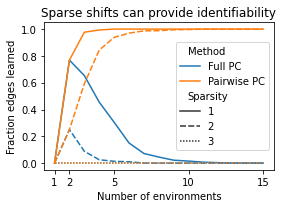

In [22]:
plt.figure(figsize=(4, 3))
sns.lineplot(
    data=df,
    x='Number of environments',
    y='Fraction edges learned',
    hue='Method',
    style='Sparsity',
    ci=None,
    # palette='gist_heat'
)
plt.title('Sparse shifts can provide identifiability')
plt.xticks([1, 2, 5, 10, 15])
plt.tight_layout()
plt.savefig('./figures/pairwise_oracle_pc_simulation.pdf')
plt.show()

## Causal dag tools

In [13]:
from causaldag import DAG, PDAG

In [114]:
def dag2cpdag(adj, targets=None):
    """Converts an adjacency matrix to the cpdag adjacency matrix, with potential interventions"""
    dag = DAG().from_amat(adj)
    cpdag = dag.cpdag()
    if targets is None:
        return cpdag.to_amat()[0]
    else:
        return dag.interventional_cpdag(
                [targets], cpdag=cpdag
            ).to_amat()[0]

def cpdag2dags(adj):
    """Converts a cpdag adjacency matrix to a list of all dags"""
    adj = np.asarray(adj)
    dags_elist = list(PDAG().from_amat(adj).all_dags())
    dags = []
    for elist in dags_elist:
        G = np.zeros((3, 3))
        elist = np.asarray(list(elist))
        G[elist[:, 0], elist[:, 1]] = 1
        dags.append(G)
    
    return dags

# def intervene_on_cpdag(adj, targets=[]):
#     cpdag = 

In [223]:
class FullPC:
    def __init__(self, dag):
        self.domains_ = []
        self.interv_targets_ = set()
        self.dag = dag  # adj matrix
        
    def add_domain(self, interventions):
        self.interv_targets_.update(interventions)
        self.domains_.append(interventions)
        
    def get_mec_dags(self):
        if len(self.domains_) == 1:
            return cpdag2dags(dag2cpdag(self.dag))
        else:
            intv_cpdag = dag2cpdag(self.dag, list(self.interv_targets_))
            return cpdag2dags(intv_cpdag)
    
    def get_mec_cpdag(self):
        if len(self.domains_) == 1:
            return dag2cpdag(self.dag)
        else:
            intv_cpdag = dag2cpdag(self.dag, list(self.interv_targets_))
            return intv_cpdag
    
class PairwisePC:
    def __init__(self, dag):
        self.interv_targets_ = []
        self.dag = dag  # adj matrix
        self.union_cpdag_ = np.zeros(dag.shape)

    def add_domain(self, interventions):        
        for prior_targets in self.interv_targets_:
            pairwise_targets = np.unique(np.hstack((prior_targets, interventions)))
            intv_cpdag = dag2cpdag(self.dag, pairwise_targets)
            self.union_cpdag_ += intv_cpdag
        
        self.interv_targets_.append(interventions)
        
    def get_mec_dags(self):
        if len(self.interv_targets_) == 1:
            return cpdag2dags(dag2cpdag(self.dag))
        else:
            min_cpdag = (-self.union_cpdag_ <= np.min(-self.union_cpdag_)).astype(int)
            return cpdag2dags(min_cpdag)
        
    def get_mec_cpdag(self):
        if len(self.interv_targets_) == 1:
            return dag2cpdag(self.dag)
        else:
            min_cpdag = (-self.union_cpdag_ <= np.min(-self.union_cpdag_)).astype(int)
            return min_cpdag

In [224]:
def get_tpr(true_dag, cpdag):
    np.testing.assert_array_equal(true_dag, np.tril(true_dag))
    tp = len(np.where((true_dag + cpdag - cpdag.T) == 2)[0])
    n_edges = np.sum(true_dag)
    return tp / n_edges

def get_fpr(true_dag, cpdag):
    np.testing.assert_array_equal(true_dag, np.tril(true_dag))
    fp = len(np.where((true_dag + cpdag.T - cpdag) == 2)[0])
    n_edges = np.sum(true_dag)
    return fp / n_edges

In [234]:
dag = np.asarray([[0, 0, 0], [1, 0 ,0], [1, 1, 0]])

print('Pairwise')
ppc = PairwisePC(dag)
ppc.add_domain([0, 1, 2])
print(len(ppc.get_mec_dags()))
ppc.add_domain([0, 1, 2])
print(len(ppc.get_mec_dags()))

print('Full')
fpc = FullPC(dag)
fpc.add_domain([0, 1, 2])
print(len(fpc.get_mec_dags()))
fpc.add_domain([0, 1, 2])
print(len(fpc.get_mec_dags()))

Pairwise
6
6
Full
6
6


In [251]:
results_mat = []
n_environments = 15
n_reps = 100
dag = np.asarray([[0, 0, 0], [1, 0 ,0], [1, 1, 0]])

for rep in range(n_reps):
    for sparsity in [1, 2, 3]:
        fpc = FullPC(dag)    
        ppc = PairwisePC(dag)
        for n_env in range(1, n_environments+1):
            interventions = np.random.choice(3, sparsity, replace=False)
            fpc.add_domain(interventions)
            ppc.add_domain(interventions)
            
            cpdag = fpc.get_mec_cpdag()
            results_mat.append([
                rep, 'PC (pool all)', sparsity, n_env, len(fpc.get_mec_dags()), get_tpr(dag, cpdag), get_fpr(dag, cpdag)
            ])

            cpdag = ppc.get_mec_cpdag()
            results_mat.append([
                rep, 'PC (pool pairwise)', sparsity, n_env, len(ppc.get_mec_dags()), get_tpr(dag, cpdag), get_fpr(dag, cpdag)
            ])

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/graphical_models/custom_types.py:13: UserWarning: [Need name!] still needs to be tested. If you intend to use this method, please submit a pull request.
  warn(s)


In [252]:
df = pd.DataFrame(
    results_mat,
    columns=[
        'Rep', 'Method', 'Sparsity', 'Number of environments',
        'Number of possible DAGs', 'True positive rate', 'False positive rate'
    ])

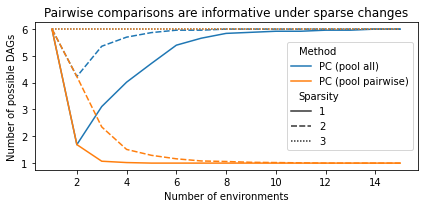

In [253]:
plt.figure(figsize=(6, 3))
sns.lineplot(
    data=df,
    x='Number of environments',
    y='Number of possible DAGs',
    hue='Method',
    style='Sparsity',
    ci=None,
    # palette='gist_heat'
)
plt.title('Pairwise comparisons are informative under sparse changes')
plt.tight_layout()
plt.savefig('./figures/pairwise_oracle_pc_simulation.pdf')
plt.show()